## EDA

In [1]:
# import necessary packages

#preprocessing
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic
import pickle5 as pickle
from tqdm import tqdm

# modeling
import statsmodels.api as sm
from sklearn import linear_model as lm
from sklearn.model_selection import GridSearchCV, train_test_split,KFold
import sklearn.naive_bayes as nb
from sklearn.metrics import plot_confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from sklearn import metrics

In [2]:
# figure set-up

sns.set(rc = {'axes.titlesize': 15,
             'axes.labelsize': 15,
             'xtick.labelsize': 10,
             'ytick.labelsize': 10,
             'figure.figsize': (16, 9)})

In [3]:
# import pickle file
df = pickle.load(open('hmda_2017_il_data_all_records.pkl', "rb"))

In [4]:
df.head()

,loan_type,loan_amount_000s,preapproval,action_taken,applicant_ethnicity,black,applicant_sex,applicant_income_000s,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
respondent_id,,,,,,,,,,,,
76-0503625,Conventional,8.0,0,withdrawn,0,0,1,44.0,77500.0,151.240005,1761.0,297.0
81-5294275,Conventional,206.0,0,withdrawn,0,0,0,74.0,77500.0,151.240005,1761.0,297.0
0000917742,Conventional,550.0,0,denied,0,0,1,183.0,77500.0,67.089996,449.0,472.0
36-3987946,Conventional,259.0,1,denied,0,0,0,122.0,77500.0,78.790001,627.0,369.0
36-4327855,Conventional,219.0,0,withdrawn,0,0,0,62.0,77500.0,136.029999,1194.0,1308.0


In [5]:
df.shape

(19460, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19460 entries, 76-0503625 to 48-1148159
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   loan_type                       19460 non-null  object 
 1   loan_amount_000s                19460 non-null  float64
 2   preapproval                     19460 non-null  int64  
 3   action_taken                    19460 non-null  object 
 4   applicant_ethnicity             19460 non-null  int64  
 5   black                           19460 non-null  int64  
 6   applicant_sex                   19460 non-null  int64  
 7   applicant_income_000s           19460 non-null  float64
 8   hud_median_family_income        19460 non-null  float64
 9   tract_to_msamd_income           19460 non-null  float64
 10  number_of_owner_occupied_units  19460 non-null  float64
 11  number_of_1_to_4_family_units   19460 non-null  float64
dtypes: float64(6), int64(4)

In [7]:
# action_taken is the label variable(categorical)
# show the amount of observation under each category
df['action_taken'].value_counts()

withdrawn    10410
denied        7194
approved      1856
Name: action_taken, dtype: int64

Text(0, 0.5, 'frequency')

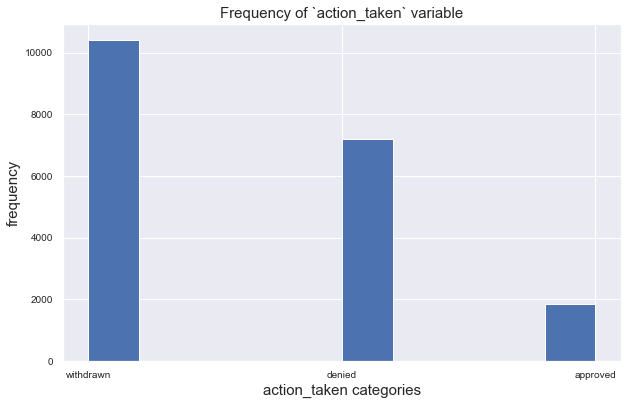

In [8]:
# the histogram of label variable - action_taken
sns.set(rc = {'axes.titlesize': 15,
             'axes.labelsize': 15,
             'xtick.labelsize': 10,
             'ytick.labelsize': 10,
             'figure.figsize': (10, 6.2)})
plt.hist(df['action_taken'])
plt.title('Frequency of `action_taken` variable')
plt.xlabel('action_taken categories')
plt.ylabel('frequency')

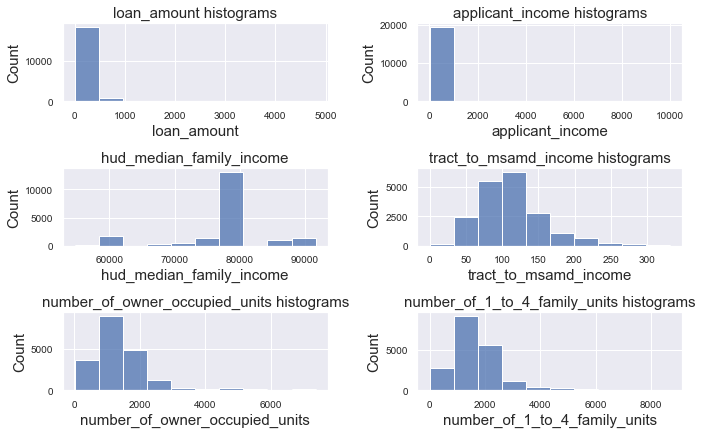

In [9]:
# feature transformation
# plotting all the continuous variables
plt.subplot(3,2,1)#n_rows, n_columns, index
sns.histplot(data = df, x = 'loan_amount_000s', bins = 10)
plt.xlabel('loan_amount')
plt.title("loan_amount histograms")
plt.subplot(3,2,2)#n_rows, n_columns, index
sns.histplot(data = df, x = 'applicant_income_000s', bins = 10)
plt.xlabel('applicant_income')
plt.title("applicant_income histograms")
plt.subplot(3,2,3)#n_rows, n_columns, index
sns.histplot(data = df, x = 'hud_median_family_income', bins = 10)
plt.xlabel('hud_median_family_income')
plt.title("hud_median_family_income")
plt.subplot(3,2,4)#n_rows, n_columns, index
sns.histplot(data = df, x = 'tract_to_msamd_income', bins = 10)
plt.xlabel('tract_to_msamd_income')
plt.title("tract_to_msamd_income histograms")
plt.subplot(3,2,5)#n_rows, n_columns, index
sns.histplot(data = df, x = 'number_of_owner_occupied_units', bins = 10)
plt.xlabel('number_of_owner_occupied_units')
plt.title("number_of_owner_occupied_units histograms")
plt.subplot(3,2,6)#n_rows, n_columns, index
sns.histplot(data = df, x = 'number_of_1_to_4_family_units', bins = 10)
plt.xlabel('number_of_1_to_4_family_units')
plt.title("number_of_1_to_4_family_units histograms")
plt.tight_layout()

I believe the variable `loan_amount` and `applicant_income` need transformation since the histogram of the two variables are right-skewed. So I did log transformation as the following:

Text(0.5, 1.0, 'log applicant_income histograms')

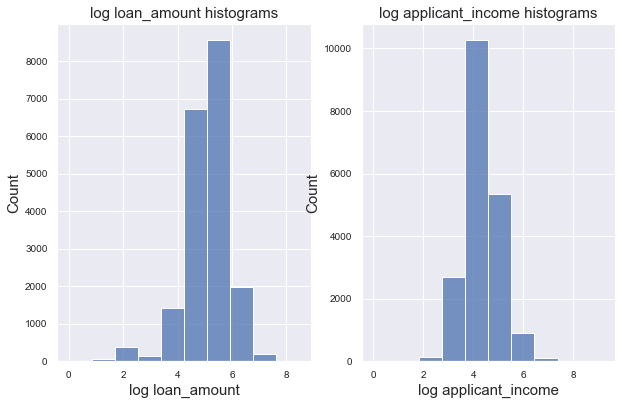

In [10]:
df['log_loan_amount_000s'] = np.log(df['loan_amount_000s'])
df['log_applicant_income_000s'] = np.log(df['applicant_income_000s'])
plt.subplot(1,2,1)#n_rows, n_columns, index
sns.histplot(data = df, x = 'log_loan_amount_000s', bins = 10)
plt.xlabel('log loan_amount')
plt.title("log loan_amount histograms")
plt.subplot(1,2,2)#n_rows, n_columns, index
sns.histplot(data = df, x = 'log_applicant_income_000s', bins = 10)
plt.xlabel('log applicant_income')
plt.title("log applicant_income histograms")

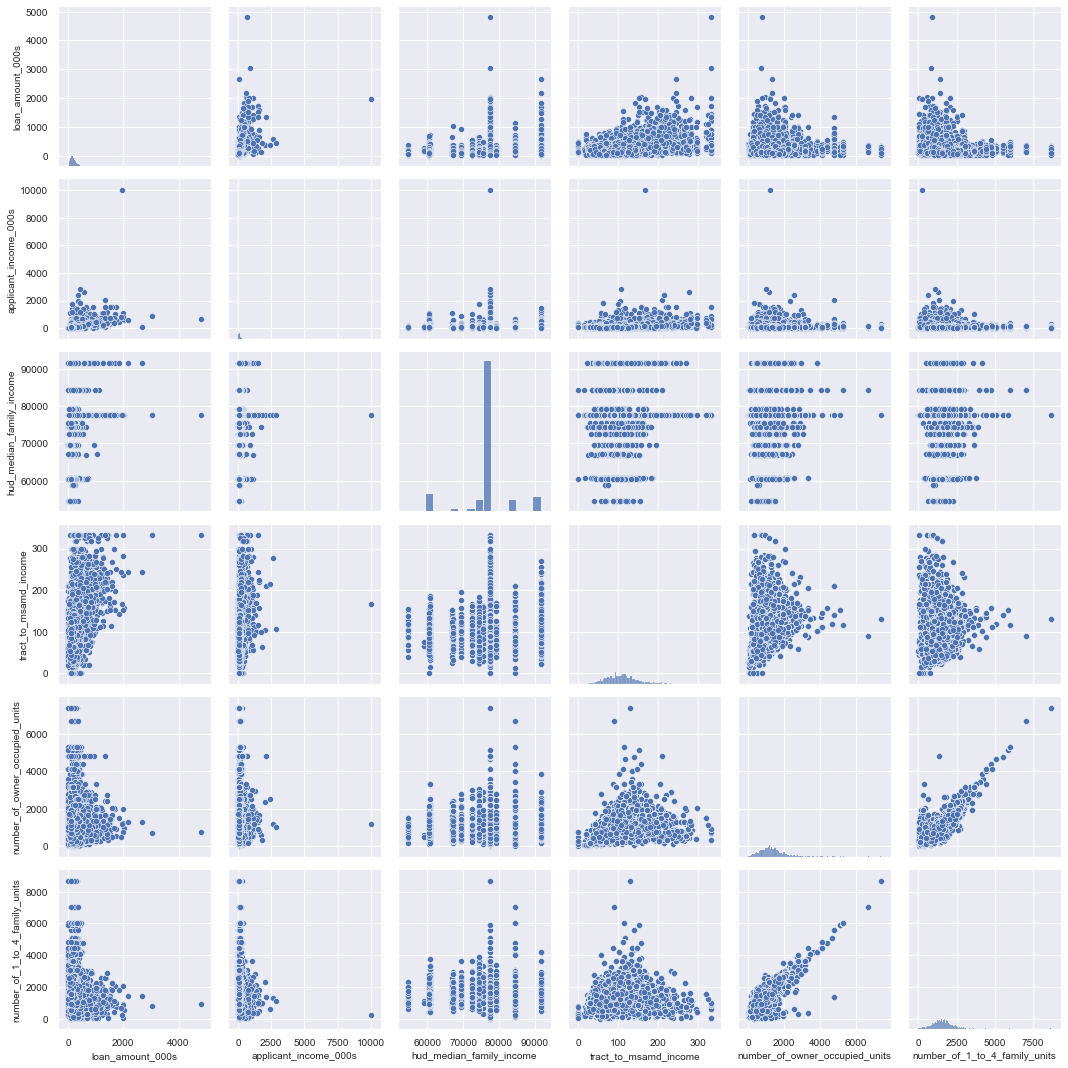

In [11]:
## scatter plots between continuous features
sns.set(rc = {'axes.titlesize': 10,
             'axes.labelsize': 10,
             'xtick.labelsize': 10,
             'ytick.labelsize': 10,
             'figure.figsize': (24, 13.5)})
sns.pairplot(df[['loan_amount_000s','applicant_income_000s',
              'hud_median_family_income','tract_to_msamd_income','number_of_owner_occupied_units',
               'number_of_1_to_4_family_units']])
plt.tight_layout()

Yes. I have found a linear relationship between the variables `number_of_owner_occupied_units` and `number_of_1_to_4_family_units`. I may exclude one of them when starting to build model.

Text(0, 0.5, 'loan amount')

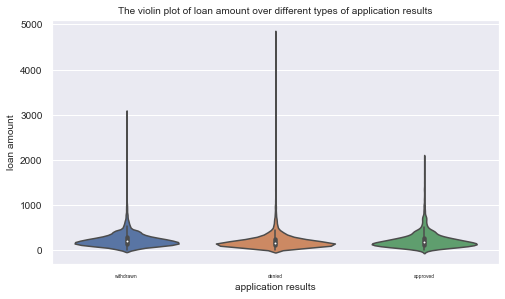

In [12]:
## the violin plot between action_taken(label variable) and loan_amount_000s
sns.set(rc = {'axes.titlesize': 10,
             'axes.labelsize': 10,
             'xtick.labelsize': 5,
             'ytick.labelsize': 10,
             'figure.figsize': (8, 4.5)})
ax = sns.violinplot(x='action_taken', y='loan_amount_000s', data=df)
plt.title('The violin plot of loan amount over different types of application results')
plt.xlabel('application results')
plt.ylabel('loan amount')

I found the distribution of loan amount is very right-skewness, especially for the application result is `denied`, and I believe the reason why application is denied is partially caused by too large loan amount.

Text(0, 0.5, 'applicant income')

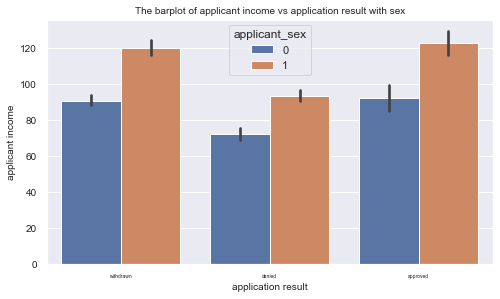

In [13]:
#bar plot of income across sex over different categories of action_taken(label variable)
ax = sns.barplot(x="action_taken", y="applicant_income_000s", hue="applicant_sex", data=df)
plt.title('The barplot of applicant income vs application result with sex')
plt.xlabel('application result')
plt.ylabel('applicant income')

Please be noted that `0` stands for female and `1` stands for male. I found for each application result, female's income is lower than male. Also, The avreage income of applicants whose applications are approved is higher than that of whose applications are denied.

## Inference

In [15]:
## data preparation
df = df.reset_index()
df_prepped = df.drop(columns = ['loan_type','respondent_id']).join(
    pd.get_dummies(df['loan_type'], drop_first = True)
)
df_prepped['action_taken'] = df_prepped['action_taken'].astype('category')
y = df_prepped['action_taken']
x = df_prepped.drop(columns = ['action_taken'])
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size = 0.8, 
                                                    random_state = 432)
ss = StandardScaler()
x_train_std = pd.DataFrame(ss.fit(x_train).transform(x_train),
                           columns = x_train.columns,
                           index = x_train.index)

x_test_std = pd.DataFrame(ss.fit(x_test).transform(x_test),
                          columns = x_test.columns, 
                          index = x_test.index)
x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

In [16]:
## MNLogit Regularization
param_grid = {
    'C': 10.0**np.arange(-5, 1, step = 1),
}

lr_cv = lm.LogisticRegression(penalty = 'l1', solver = 'saga',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy')
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

/Users/juli/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/juli/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/juli/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/juli/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 0.01}

| | action_taken = 0 | 
| --- | --- |
| loan_amount |   0.0451 |
|  |   (0.0268) |
| black |   0.1184 |
|  |   (0.0177) |
| family_income |   -0.0478 |
|  |   (0.0285) |
|  Features|    15|
|  Observations|    15568|
|  Pseudo R-squared|    0.028|

| | action_taken = 1 | 
| --- | --- |
| preapproval |   -0.0848 |
|  |   (0.0257) |
| applicant_income |   -0.0064 |
|  |   (0.0201) |
| family_income |   0.0968 |
|  |   (0.0274) |
|  Features|    15|
|  Observations|    15568|
|  Pseudo R-squared|    0.028|

In [17]:
## Refit MNLogit Model with selected features
fit_logit_reg = sm.MNLogit(y_train, x_train_std
                          ).fit_regularized(alpha = 1/best['C'],
                                            L1_wt = 1,
                                            qc_tol = 1e3)
## show the summary of MNLogit Model
fit_logit_reg.summary2()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9259210852222489
            Iterations: 51
            Function evaluations: 52
            Gradient evaluations: 51


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: MNLogit
===============================================================================
Model:                   MNLogit              Pseudo R-squared:     0.028      
Dependent Variable:      action_taken         AIC:                  28131.2596 
Date:                    2021-05-14 21:23     BIC:                  28261.3602 
No. Observations:        15568                Log-Likelihood:       -14049.    
Df Model:                15                   LL-Null:              -14446.    
Df Residuals:            15551                LLR p-value:          9.8761e-160
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          51.0000                                               
-------------------------------------------------------------------------------
       action_taken = 0         Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
                         const  1.1793   0.0280  42.0760 0.0000  1.1244  1.2342
              loan_amount_000s  0.0451   0.0268   1.6844 0.0921 -0.0074  0.0977
                   preapproval  0.0008   0.0265   0.0286 0.9772 -0.0512  0.0527
           applicant_ethnicity  0.0419   0.0179   2.3412 0.0192  0.0068  0.0770
                         black  0.1184   0.0177   6.7020 0.0000  0.0838  0.1530
                 applicant_sex  0.0011   0.0174   0.0622 0.9504 -0.0331  0.0353
         applicant_income_000s  0.0000      nan      nan    nan     nan     nan
      hud_median_family_income -0.0478   0.0285  -1.6770 0.0935 -0.1037  0.0081
         tract_to_msamd_income  0.0000      nan      nan    nan     nan     nan
number_of_owner_occupied_units  0.0000      nan      nan    nan     nan     nan
 number_of_1_to_4_family_units  0.0000      nan      nan    nan     nan     nan
          log_loan_amount_000s  0.0000      nan      nan    nan     nan     nan
     log_applicant_income_000s -0.3158   0.0251 -12.6017 0.0000 -0.3649 -0.2667
                           FHA  0.1159   0.0183   6.3436 0.0000  0.0801  0.1517
                       FSA/RHS  0.0001   0.0169   0.0079 0.9937 -0.0331  0.0333
                            VA  0.0057   0.0175   0.3270 0.7436 -0.0285  0.0400
-------------------------------------------------------------------------------
        action_taken = 1         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
                         const   1.5747   0.0268 58.7948 0.0000  1.5222  1.6272
              loan_amount_000s   0.0000      nan     nan    nan     nan     nan
                   preapproval  -0.0848   0.0257 -3.2988 0.0010 -0.1352 -0.0344
           applicant_ethnicity   0.0000      nan     nan    nan     nan     nan
                         black   0.0000      nan     nan    nan     nan     nan
                 applicant_sex   0.0000      nan     nan    nan     nan     nan
         applicant_income_000s  -0.0064   0.0201 -0.3164 0.7517 -0.0458  0.0331
      hud_median_family_income   0.0968   0.0274  3.5295 0.0004  0.0431  0.1506
         tract_to_msamd_income   0.0071   0.0191  0.3731 0.7091 -0.0303  0.0446
number_of_owner_occupied_units   0.0000      nan     nan    nan     nan     nan
 number_of_1_to_4_family_units   0.0000      nan     nan    nan     nan     nan
          log_loan_amount_000s   0.0194   0.0225  0.8594 0.3901 -0.0248  0.0635
     log_applicant_income_000s   0.0000      nan     nan    nan     nan     nan
                           FHA   0.0000      nan     nan    nan     nan     nan
                       FSA/RHS   0.0000      nan     nan    nan     nan     nan
                            VA   0.0000      nan     nan    nan     nan     nan
===============================================================================

"""

In [18]:
# get marginal effect summary of MNLogit Model
fit_logit_reg.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:           action_taken
Method:                          dydx
At:                           overall
==================================================================================================
         action_taken=approved      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
loan_amount_000s                  -0.0017        nan        nan        nan         nan         nan
preapproval                        0.0049        nan        nan        nan         nan         nan
applicant_ethnicity               -0.0016        nan        nan        nan         nan         nan
black                             -0.0046        nan        nan        nan         nan         nan
applicant_sex                  -4.179e-05        nan        nan        nan         nan         nan
applicant_income_000s              0.0004        nan        nan        nan         nan         nan
hud_median_family_income          -0.0038        nan        nan        nan         nan         nan
tract_to_msamd_income             -0.0004        nan        nan        nan         nan         nan
number_of_owner_occupied_units          0        nan        nan        nan         nan         nan
number_of_1_to_4_family_units           0        nan        nan        nan         nan         nan
log_loan_amount_000s              -0.0011        nan        nan        nan         nan         nan
log_applicant_income_000s          0.0122        nan        nan        nan         nan         nan
FHA                               -0.0045        nan        nan        nan         nan         nan
FSA/RHS                        -5.167e-06        nan        nan        nan         nan         nan
VA                                -0.0002        nan        nan        nan         nan         nan
--------------------------------------------------------------------------------------------------
           action_taken=denied      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
loan_amount_000s                   0.0100        nan        nan        nan         nan         nan
preapproval                        0.0157        nan        nan        nan         nan         nan
applicant_ethnicity                0.0093        nan        nan        nan         nan         nan
black                              0.0263        nan        nan        nan         nan         nan
applicant_sex                      0.0002        nan        nan        nan         nan         nan
applicant_income_000s              0.0012        nan        nan        nan         nan         nan
hud_median_family_income          -0.0284        nan        nan        nan         nan         nan
tract_to_msamd_income             -0.0013        nan        nan        nan         nan         nan
number_of_owner_occupied_units          0        nan        nan        nan         nan         nan
number_of_1_to_4_family_units           0        nan        nan        nan         nan         nan
log_loan_amount_000s              -0.0036        nan        nan        nan         nan         nan
log_applicant_income_000s         -0.0702        nan        nan        nan         nan         nan
FHA                                0.0258        nan        nan        nan         nan         nan
FSA/RHS                         2.982e-05        nan        nan        nan         nan         nan
VA                                 0.0013        nan        nan        nan         nan         nan
--------------------------------------------------------------------------------------------------
        action_taken=withdrawn      dy/dx    std err          z      P>|z|      [0.025      0.975]


## Prediction

### null model

In [19]:
## null model accuracy
y_hat_dic = {}
for (k,v) in zip(np.unique(y_train, return_counts = True)[0], 
                 np.unique(y_train, return_counts = True)[1]):
    y_hat_dic[k] = v
null_acc = np.mean(y_test == max(y_hat_dic))
null_acc

0.5382836587872559

### MNLgoit ACC

In [20]:
## MNLogit model accuracy
yhat = y_test.cat.categories[fit_logit_reg.predict(x_test_std).idxmax(axis = 1)]
#yhat
acc_logit = np.mean(yhat == y_test)
acc_logit

0.5680883864337102

### Naive Bayes

0.5493319630010277


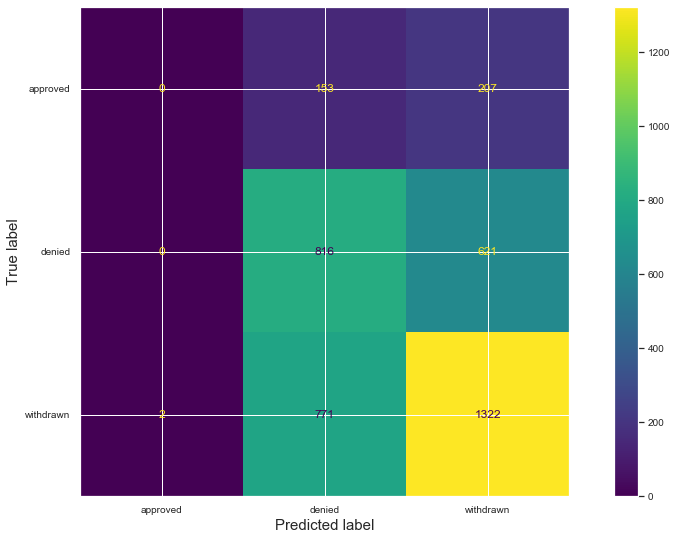

In [21]:
## naive bayes model accuracy
sns.set(rc = {'axes.titlesize': 15,
             'axes.labelsize': 15,
             'xtick.labelsize': 10,
             'ytick.labelsize': 10,
             'figure.figsize': (16, 9)})
gnb = nb.GaussianNB()
gnb.fit(x_train, y_train)

nb_acc = gnb.score(x_test, y_test)
print(nb_acc)

plot_confusion_matrix(gnb, x_test, y_test)
plt.show()

### KNN

In [23]:
## KNN model accuracy
kf = KFold(n_splits = 5, random_state = 490, shuffle = True)
k_nbrs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,60,70,80,90,100, 110, 120,130,140,150]
accuracy = {}


for k in tqdm(k_nbrs):
    acc = []
    for trn, tst in kf.split(x_train_std):
        yhat = KNeighborsClassifier(n_neighbors = k
        ).fit(x_train_std.iloc[trn], y_train.iloc[trn]
        ).predict(x_train_std.iloc[tst])        
        acc.append(np.mean(yhat == y_train.iloc[tst]))
    accuracy[k] = np.mean(acc)

100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


In [24]:
best_k = max(accuracy, key = accuracy.get)
print(best_k)

100


In [25]:
%%time
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(x_train_std, y_train)
acc_knn = knn.score(x_test_std, y_test)
print(acc_knn)

0.5688591983556013
CPU times: user 2.23 s, sys: 835 ms, total: 3.06 s
Wall time: 1.82 s


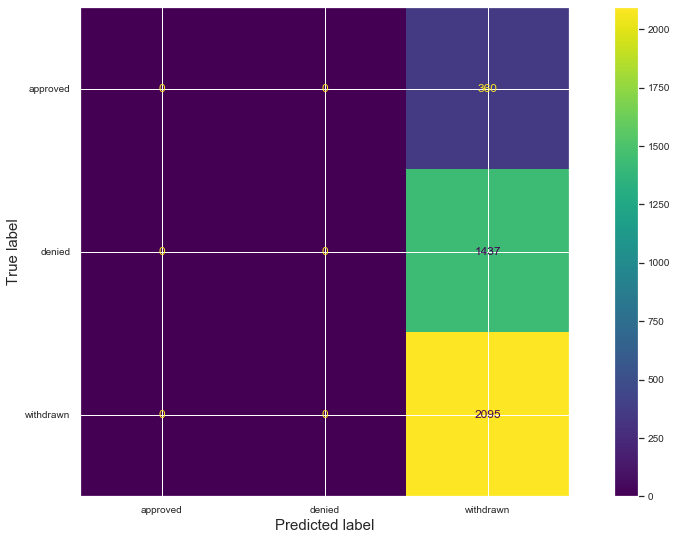

In [26]:
plot_confusion_matrix(knn, x_test, y_test)
plt.show()

### Random Forest Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5629496402877698


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


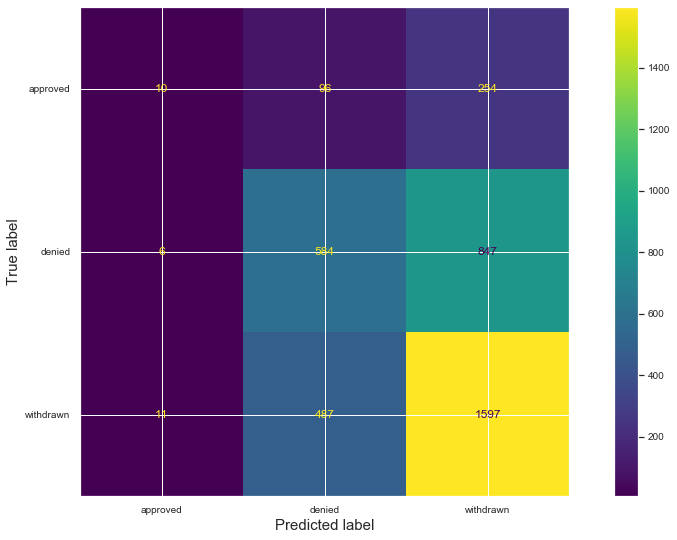

In [27]:
## random forest model accuracy and confusion matrix
clf_rf = RandomForestClassifier(n_estimators = 500,
                          random_state = 432,
                          max_features = 'sqrt',
                          oob_score = True,
                          verbose = 1)
clf_rf.fit(x_train, y_train)
rf_acc = clf_rf.score(x_test, y_test)
print(rf_acc)
plot_confusion_matrix(clf_rf, x_test, y_test)
plt.show()

### Adaboosting Model

In [28]:
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'learning_rate': [0.1,0.5,1,1.5]
}

ada_cv = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
                            max_depth = 1),
                           random_state = 490)
grid_search = GridSearchCV(ada_cv, param_grid,
                          cv = 5,
                          scoring = 'accuracy'
                          ).fit(x_train, y_train)

best_e_lr = grid_search.best_params_
best_e_lr

{'learning_rate': 0.5, 'n_estimators': 50}

In [29]:
clf_ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
                            max_depth = 1),
                           random_state = 490,
                           n_estimators = best_e_lr['n_estimators'],
                           learning_rate = best_e_lr['learning_rate'])
clf_ada.fit(x_train, y_train)

ada_acc = clf_ada.score(x_test, y_test)
ada_acc

0.567060637204522

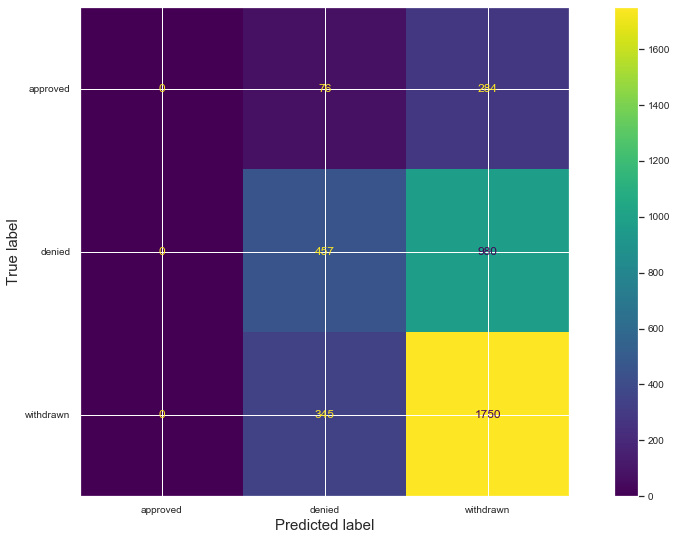

In [30]:
plot_confusion_matrix(clf_ada, x_test, y_test)
plt.show()

### Stacking

In [31]:
print("Naive Bayes", nb_acc)
print("rf acc: ", rf_acc)
print("ada acc: ", ada_acc)

Naive Bayes 0.5493319630010277
rf acc:  0.5629496402877698
ada acc:  0.567060637204522


In [32]:
estimators = [
    ('knn',gnb),
    ('rf', clf_rf),
    ('ada', clf_ada)
]
stack_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(solver = 'saga'), cv = 5
)
stack_clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

StackingClassifier(cv=5,
                   estimators=[('knn', GaussianNB()),
                               ('rf',
                                RandomForestClassifier(max_features='sqrt',
                                                       n_estimators=500,
                                                       oob_score=True,
                                                       random_state=432,
                                                       verbose=1)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                   learning_rate=0.5,
                                                   random_state=490))],
                   final_estimator=LogisticRegression(solver='saga'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


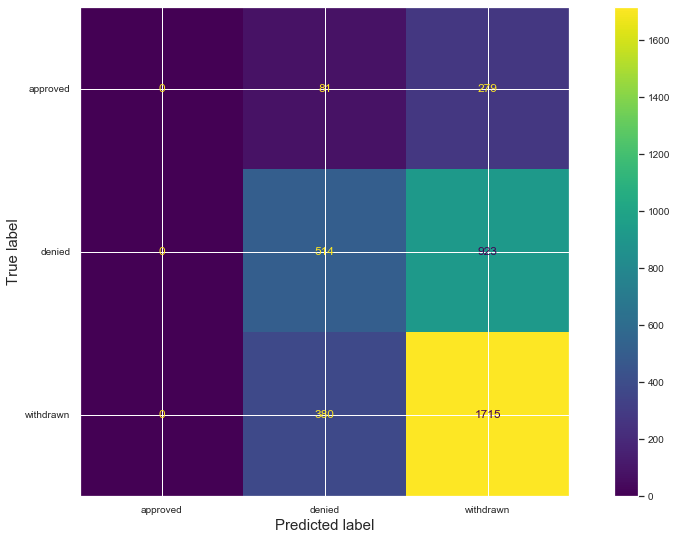

In [33]:
plot_confusion_matrix(stack_clf, x_test, y_test)
plt.show()

In [34]:
stack_acc = stack_clf.score(x_test, y_test)
stack_acc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


0.5727132579650566

### Comparison

| Model | Accuracy | 
| --- | --- |
| Null Model |   0.5383 |
| MNLogit Model |   0.5527 |
| Naive Bayes Model |   0.5470 |
| KNN |   0.5689 |
| Random Forest Model |   0.5632 |
| Adaboosting Model |   0.5671 |
| Stacking Model |   0.5725 |

MNLogit Model has the strongest interpretation power and flexibility. I will choose stacking model combining Naive Nayes model, Random Forest model and Adaboosting model given the metric of accuracy. 